In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
reviews = pd.read_csv("/kaggle/input/flipkart/Dataset-SA.csv")

# Convert 'Rate' to numeric
reviews['Rate'] = pd.to_numeric(reviews['Rate'], errors='coerce')

# Convert 'product_price' to numeric (as you already did)
reviews['product_price'] = pd.to_numeric(reviews['product_price'], errors='coerce')

In [6]:
# Basic exploration
print("Dataset Head:")
print(reviews.head())
print("\nDataset Shape:", reviews.shape)
print("\nDataset Info:")
print(reviews.info())
print("\nDataset Description:")
print(reviews.describe())


Dataset Head:
                                        product_name  product_price  Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0   5.0   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0   5.0   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0   3.0   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0   1.0   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...         3999.0   3.0   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok ok product   

  Sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4   neutral  


In [ ]:
# Check for missing values
print("\nMissing Values:")
print(reviews.isnull().sum())

# Analyze sentiment distribution
print("\nSentiment Distribution:")
print(reviews['Sentiment'].value_counts())


In [7]:
# Analyze rating distribution
print("\nRating Distribution:")
print(reviews['Rate'].value_counts())

# Group by product to get aggregate stats
product_stats = reviews.groupby('product_name').agg({
    'Rate': ['mean', 'count'],
    'product_price': 'first',
    'Sentiment': lambda x: (x == 'positive').sum() / len(x)  # Positive sentiment ratio
}).reset_index()
product_stats.columns = ['product_name', 'avg_rating', 'review_count', 'product_price', 'positive_ratio']
print("\nProduct Stats:")
print(product_stats)


Rating Distribution:
Rate
5.0    118765
4.0     41894
1.0     21300
3.0     16599
2.0      6491
Name: count, dtype: int64

Product Stats:
                                          product_name  avg_rating  \
0    1170BLBR Unique New Day  Date Analog Watch   F...    3.986667   
1    288SDTL TIMEWEAR Silver Pink Dial Stainless St...    4.406915   
2         38024PP25 Minimalists Analog Watch   For Men    4.888889   
3    3D METRO SUPER STORE JUICERGduumy 1 Juicer1 Ha...    3.670000   
4    3D METRO SUPER STORE METROMIXER Pro 0 Juicer 1...    4.750000   
..                                                 ...         ...   
953  tHemiStO Beginners 8 in 1 Soldering iron Kit 2...    4.240000   
954  the indian casa Cricket Net 10x20 Feet Nylon C...    3.923077   
955  thos 5 Layer Simple BookshelfMultipurpose Rack...    3.385000   
956  thos 5 Layer Simple BookshelfMultipurpose Rack...    3.406897   
957  vesco Kiddo 14" Cycle for Kids Bicycles age 3 ...    4.228571   

     review_count  p

In [8]:
reviews['summary_length'] = reviews['Summary'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
reviews['review_length'] = reviews['Review'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Create a combined text field for semantic search
reviews['combined_text'] = reviews['Review'].fillna('') + ' ' + reviews['Summary'].fillna('')

In [9]:
# Filter products with sufficient data (e.g., at least 5 reviews and summary > 10 words)
filtered_reviews = reviews[reviews.groupby('product_name')['product_name'].transform('size') >= 5]
filtered_reviews = filtered_reviews[filtered_reviews['summary_length'] > 10]


In [10]:
# Remove duplicates if any
filtered_reviews = filtered_reviews.drop_duplicates(subset=['product_name', 'Review', 'Summary'])

# Save cleaned dataset for recommender system
filtered_reviews.to_csv("flipkart_reviews_cleaned.csv", index=False)

In [11]:
print("\nNaN Values in Rate:", reviews['Rate'].isnull().sum())


NaN Values in Rate: 3


In [12]:
print("\nUnique Values in Rate:")
print(reviews['Rate'].unique())


Unique Values in Rate:
[ 5.  3.  1.  4.  2. nan]


In [ ]:
reviews['Rate'].fillna(reviews['Rate'].median(), inplace=True)

In [13]:
print("\nData Types:")
print(reviews.dtypes)


Data Types:
product_name       object
product_price     float64
Rate              float64
Review             object
Summary            object
Sentiment          object
summary_length      int64
review_length       int64
combined_text      object
dtype: object


In [14]:
from collections import Counter
words = ' '.join(reviews['combined_text']).split()
print("\nMost Common Words:", Counter(words).most_common(20))


Most Common Words: [('good', 99381), ('product', 85583), ('nice', 49842), ('very', 49476), ('is', 48563), ('the', 45366), ('and', 37055), ('not', 32432), ('it', 31800), ('for', 30074), ('quality', 29330), ('this', 24317), ('i', 22800), ('in', 22414), ('to', 21742), ('awesome', 19121), ('of', 17218), ('best', 16656), ('a', 16261), ('its', 14517)]


In [15]:
reviews['product_type'] = reviews['product_name'].apply(
    lambda x: 'Air Cooler' if 'Cooler' in x else 'Dinner Set' if 'Opalware' in x else 'Other'
)
print("\nProduct Type Stats:")
print(reviews.groupby('product_type').agg({
    'Rate': 'mean',
    'Sentiment': lambda x: (x == 'positive').sum() / len(x)
}))


Product Type Stats:
                  Rate  Sentiment
product_type                     
Air Cooler    4.102051   0.819410
Dinner Set    4.374453   0.883577
Other         4.112929   0.809308


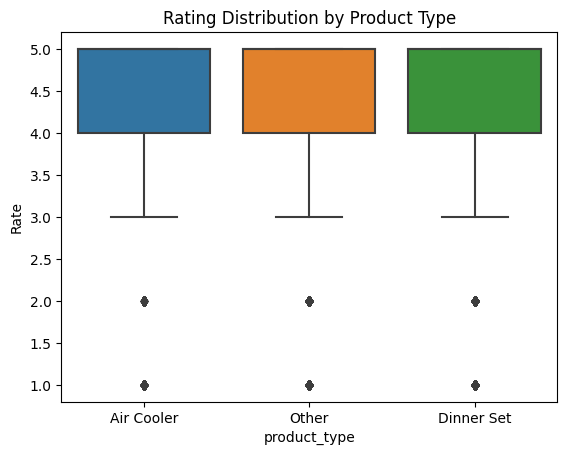

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='product_type', y='Rate', data=reviews)
plt.title("Rating Distribution by Product Type")
plt.show()

In [17]:
reviews['combined_text'] = reviews['combined_text'].str.replace('[^\w\s]', '', regex=True)

In [18]:
print("\nFiltered Dataset Shape:", filtered_reviews.shape)


Filtered Dataset Shape: (36397, 9)
